## Example workflow notebook

This notebook shows how to use the classes and functions provided by the `epicluster` package to run MCMC inference.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import epicluster as ec

Functions to generate synthetic case series.

In [1]:
def poisson_rvs(mu):
    return scipy.stats.poisson.rvs(mu)

def negativebinomial_rvs(mu, kappa, n=1):
    n1 = kappa
    p = float(kappa) / (kappa + mu)
    return scipy.stats.nbinom.rvs(n1, p, 0, n)

def expected_cases(Rt, past_cases, serial_interval):
    if np.abs(sum(serial_interval) - 1) > 1e-6:
        raise ValueError("Serial interval does not sum to 1.")
    return Rt * np.dot(past_cases, serial_interval)

def next_cases(Rt, past_cases, serial_interval, kappa):
    expectation = expected_cases(Rt, past_cases, serial_interval)
    if kappa is not None:
        return negativebinomial_rvs(expectation, kappa)
    else:
        return poisson_rvs(expectation)

def generate_case_series(Rt_series, past_cases, serial_interval, kappa=None):
    n_past_cases = len(past_cases)
    if n_past_cases != len(serial_interval):
        raise ValueError("Past cases must be of same length as serial interval.")
    series_len = len(Rt_series)
    cases = np.zeros(series_len + n_past_cases)
    cases[:n_past_cases] = past_cases
    for i in range(series_len):
        new_case_index = i + n_past_cases
        historical_cases = cases[i:new_case_index]
        historical_cases_rev = historical_cases[::-1]
        cases[new_case_index] = next_cases(
            Rt_series[i], historical_cases_rev, serial_interval, kappa)
    cases_post_past = cases[n_past_cases:]
    days = np.arange(1, len(cases_post_past) + 1)
    df = pd.DataFrame(
        {'day': days,
        'cases': cases_post_past,
        'Rt': Rt_series})
    return df

Generate synthetic case series.

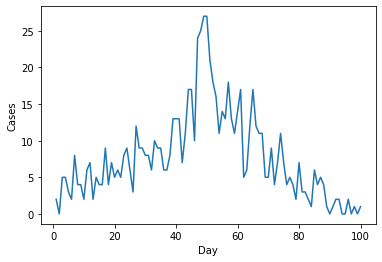

In [34]:
# Use a gamma(2, 0.5) serial interval, which is obtained by discretising a continuous distribution.
tmax = 20
w_int = [scipy.stats.gamma.cdf(x, 2, scale=2) for x in range(tmax)]
w = np.diff(w_int)
serial_interval = w / sum(w)

# pad with cases prior to t=0
past_cases = np.zeros(len(w))
past_cases[-1] = 5
past_cases[-2] = 5
past_cases[-3] = 5

# split Rt series into two segments
Rt_part_1 = np.repeat(1.3, 50)
Rt_part_2 = np.repeat(0.8, 50)
Rt_series = np.concatenate([Rt_part_1, Rt_part_2])

# generate cases
cases_df = generate_case_series(Rt_series, past_cases, serial_interval)
cases = cases_df['cases']

# plot cases
plt.plot(cases_df["day"], cases_df["cases"])
plt.xlabel("Day")
plt.ylabel("Cases")
plt.show()

Run inference using 4 MCMC chains.

In [42]:
model = ec.PoissonModel(cases, serial_interval)
n_chains = 4
posterior = ec.MCMCSampler(model, n_chains)
params, assignments, sizes = posterior.run_mcmc(Rhat_thresh=1.1, progress=True)

Iter=50, Rhat=23.075412404766297
Iter=100, Rhat=17.75951558862468
Iter=150, Rhat=7.644389110923367
Iter=200, Rhat=3.6845515753200573
Iter=250, Rhat=2.4706776492670848
Iter=300, Rhat=1.3227947337599812
Iter=350, Rhat=1.088621656368917
Converged 350 1.088621656368917


Extract the Rt value over time for each MCMC sample.

In [48]:
R_profiles = []
for R, z in zip(params, assignments):
    R_profiles.append([R[zi] for zi in z])

I'm not sure why there aren't more draws here? Does iter sum the number of steps across all chains?

In [50]:
len(R_profiles)

351

Plot the draws of Rt profiles, their mean and the true Rt series. I'm not sure how to discard the first (say) half of samples here? Also, I'm not sure how to make them line up with the true series?

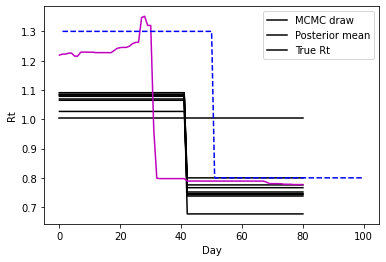

In [64]:
for i in range(10):
    plt.plot(R_profiles[i], 'k')
plt.plot(np.mean(R_profiles, axis=0), 'm')
plt.plot(cases_df["day"], cases_df["Rt"], 'b--')
plt.legend(['MCMC draw', 'Posterior mean', 'True Rt'])
plt.xlabel("Day")
plt.ylabel("Rt")
plt.show()